<a href="https://colab.research.google.com/github/VincentHeau/IA/blob/main/TP3_MLP_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3 - Classification d'images avec un MLP et un CNN et comparaison des résultats

 ## Introduction

 Ce TP vous propose d'explorer désormais les architectures de neurones convolutives. La tâche de classification d'images se fera avec le jeu de données de référence <a href="https://en.wikipedia.org/wiki/CIFAR-10">CIFAR-10</a>.

**Objectif** : classifier le jeu de données CIFAR-10 par apprentissage profond. En plus de se familiariser avec PyTorch, ce TP doit permettre d'exploirer les avantages des CNN par rapport aux MLP pour des tâches de vision.

**Objectifs pédagogiques** :
- découvrir un jeu de données de référence
- implémenter un réseau de neurones convolutif
- comparer deux architectures de réseaux de neurones

**Etapes** :
- préparer le jeu de données en découvrant les fonctionnalités de PyTorch
- implémenter deux modèles : un perceptron multicouches (MLP) et un réseau de neurones convolutif (CNN)
- comparer leurs résultats

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time


# Pour la reproductibilité du code, nous allons fixé :
seed = 11
torch.manual_seed(seed)

In [ ]:
b = torch.randn(1, 3, 32, 32)
t = torch.randn(2,3,3,3)

print(b)
print(t)

tensor([[[[-2.4950e-01, -6.5382e-01, -1.2771e-02,  ...,  3.6242e-01,
            1.3890e+00, -9.6707e-01],
          [ 1.4206e+00,  1.9017e+00,  1.2768e+00,  ...,  1.9284e-01,
            1.7032e-01, -1.0953e+00],
          [ 3.3603e-01, -1.3675e+00, -8.8419e-01,  ...,  7.6364e-01,
            7.7721e-02, -1.2768e+00],
          ...,
          [ 1.8263e-03,  1.2017e+00, -2.2225e-01,  ...,  2.6008e+00,
            1.1405e+00,  6.5771e-02],
          [ 6.3517e-01,  2.8829e-01,  1.4043e+00,  ...,  1.7966e+00,
           -1.6156e+00,  7.7798e-02],
          [-8.5777e-01,  1.4078e-01,  2.5813e+00,  ..., -5.9787e-01,
            6.2597e-03,  2.9247e-01]],

         [[ 2.3187e+00, -6.3548e-01,  8.5730e-01,  ...,  3.2386e-01,
            1.4526e+00,  1.2324e+00],
          [-6.7529e-01,  2.3644e+00,  1.2004e+00,  ..., -1.3672e+00,
           -3.4669e-01,  1.0409e+00],
          [-7.0071e-01, -6.3515e-01, -6.5579e-01,  ...,  8.1674e-01,
           -3.7053e-01, -4.8716e-01],
          ...,
     

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Le jeu de données CIFAR-10

CIFAR-10 est un jeu de données populaire en vision par ordinateur composé de 60 000 images réparties en 10 classes distinctes (avion, voiture, oiseau, chat, cerf, chien, grenouille, cheval, navire, et camion). Chaque classe comprend 6 000 échantillons, qui sont des images de 32x32 pixels.

L'une des caractéristiques intéressantes de CIFAR-10 est sa diversité d'objets et sa variété d'angles de vue, ce qui en fait un ensemble de données de référence pour la classification d'images.

Le jeu de données CIFAR-10 est largement utilisé dans la recherche en apprentissage automatique et en vision par ordinateur en raison de sa taille modeste, de sa complexité adaptée aux projets pédagogiques, et de sa capacité à tester la capacité d'un modèle à généraliser à partir de données d'images du monde réel.

![](https://cdn-images-1.medium.com/v2/resize:fit:600/1*SZnidBt7CQ4Xqcag6rd8Ew.png)

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

### 1.1 Dataset

Nous avons toujours veillé à découpler le code pré-traitant le jeu de données au code d'apprentissage du modèle afin d'avoir un code **lisible** et **modulaire**. Nous allons découvrir à présent deux fonctionnalités implémentées dans la bibliothèque PyTorch : *torch.utils.data.Dataset* et *torch.utils.data.DataLoader*.

La fonctionnalité *Dataset* permet d'utiliser des jeux de données préchargés ainsi que vos propres données. Le *Dataset* stocke les *features* et *labels* de notre jeu de données. Les [jeux de données préchargés](https://pytorch.org/vision/stable/datasets.html) comme CIFAR-10 sous-classent cette classe abstraite *Dataset* et implémentent des fonctions spécifiques au jeu de données.



In [ ]:
# Les jeux de données sont souvent déjà chargés en sous-ensembles d'entraînement et de tests
# On télécharge le jeu d'entraînement et l'on fera de même pour le jeu de données test
cifar10 = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 170498071/170498071 [00:03<00:00, 52949828.64it/s]


Extracting data/cifar-10-python.tar.gz to data


- *root* : désigne le chemin où sont stockées les données d'entraînement/de test
- *train* : spécifie l'ensemble de données d'entraînement ou de test
- *download=True* : télécharge les données depuis Internet si elles ne sont pas disponibles à la racine.
- *transform* : spécifie les transformations des caractéristiques et des étiquettes

In [ ]:
print(cifar10)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Nous allons regarder comment normaliser notre jeu de données

In [ ]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3) # tenseur des 50 000 images d'entraînement au format 3x32x32.
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
# Calcul des moyennes et écart-types de notre jeu de données pour les canaux rouge, vert et bleu:
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)
print(mean, "\n", std)

tensor([0.4914, 0.4822, 0.4465]) 
 tensor([0.2470, 0.2435, 0.2616])


In [ ]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean, std)])
)

Files already downloaded and verified


**Consigne** : Chargez de même le jeu test

In [ ]:
# .... A FAIRE ....
test_data = ???

#### Solution

In [ ]:
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean, std)])
)

Files already downloaded and verified


### 1.2 Visualisation des données

Visualisation d'images aléatoires du jeu de données.

La normalisation consiste à appliquer la formule suivante aux données x : $\frac{x - moyenne}{écart-type}$.

Pour visualiser nos données, nous souhaitons inverser cette formule pour visualiser les images avec leurs couleurs d'origine. Pour cela, on applique une formule telle que :

$\text{moyenne} = \frac{- \text{moyenne}}{\text{écart-type}}$

$\text{écart-type} = \frac{1}{\text{écart-type}}$.

Vous pouvez tester l'affichage sans cette manipulation pour constater son effet.

In [ ]:
mean = imgs.view(3, -1).mean(dim=1).numpy()
std = imgs.view(3, -1).std(dim=1).numpy()

unorm = transforms.Normalize(mean=-mean/std,
                             std=1/std)

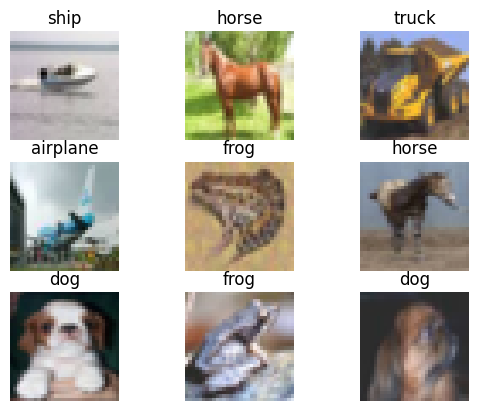

In [ ]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure()
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img = unorm(img).permute(1, 2, 0) # Pour inverser l'ordre des canaux : [3, 32, 32] à [32, 32, 3]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

### 1.3 Dataloader

La fonctionnalité *DataLoader* permet d'itérer sur une instance de *Dataset* afin d'accéder facilement aux échantillons un à un ou par batch.

La spécification *shuffle=True* permet de mélanger les données après avoir itéré sur tous les lots.

In [ ]:
train_loader = DataLoader(
    training_data,
    batch_size=64,
    shuffle=True)


In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Taille des features: {train_features.size()}")
print(f"Taille des labels: {train_labels.size()}")

Taille des features: torch.Size([64, 3, 32, 32])
Taille des labels: torch.Size([64])


**Consigne** : préparer de même le *DataLoader* pour le jeu test

In [ ]:
# .... A FAIRE ....
test_loader = ???

#### Solution

In [ ]:
test_loader = DataLoader(
    test_data,
    batch_size=64,
    shuffle=True)

In [ ]:
test_features, test_labels = next(iter(test_loader))
print(f"Taille des features: {test_features.size()}")
print(f"Taille des labels: {test_labels.size()}")

Taille des features: torch.Size([64, 3, 32, 32])
Taille des labels: torch.Size([64])


### 1.4 Visualisation des données

Nous pouvons désormais itérer à travers le jeu de données selon nos besoins. Le code ci-dessous permet de renvoyer un lot de *features* et *labels* du jeu de données d'entraînement de 64 éléments (car notre taille de batch est de 64).

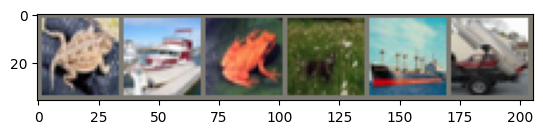

 frog  ship  frog   cat  ship truck


In [ ]:
# Récupérer des images d'entraînement de manière aléatoire :
dataiter = iter(train_loader)
train_features, train_labels = next(dataiter)

def imshow(img):
  img = unorm(img).swapaxes(0, 2).swapaxes(0, 1) # Pour inverser l'ordre des canaux : [3, 32, 32] à [32, 32, 3]
  plt.imshow(img)
  plt.show()

# Afficher les images
imshow(torchvision.utils.make_grid(train_features[0:6]))
# Afficher les labels
print(' '.join('%5s' % classes[train_labels[j]] for j in range(6)))

## 2. Implémentation des modèles

Les images sont des grilles bidimensionnelles de pixels. Nous allons comparer deux approches de traitement d'images :
- une première avec un modèle de perceptron multicouches (MLP) traitant cette structure très riche comme un vecteur de nombres, sans tenir compte de la relation spatiale entre les pixels.
- un réseau de neurones convolutif (CNN) qui prend en compte la structure spatiale des images grâce à des filtres de convolution.

### 2.1 Définir le perceptron multi-couches

Nous avons déjà vu ce modèle de réseau de neurones dans le TP précédent. Pour rendre les données images exploitables dans un perceptron multicouches, nous allons d'abord aplatir (*flatten*) chaque image à partir d'une matrice de taille 32x32 avec 3 canaux rouge, vert, bleu, en un vecteur de longueur fixe de 32x32x3 = 3072, puis nous allons les traiter dans des couches entièrement connectées.

**Consignes** :
- implémenter la classe définissant un perceptron multi-couches avec 4 couches entièrement connectées suivies de ReLU, et de tailles suivantes :
  - (input_size, 64)
  - (64, 64)
  - (64, 64)
  - (64, num_classes)
- instancier un modèle de perceptron multi-couches

In [ ]:
# .... A FAIRE ....
# Compléter la définition de la classe MLP ci-dessous

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    num_classes = ???

    self.net = nn.Sequential(
        ???
    )

  def forward(self, x):
    ???
    return x

SyntaxError: ignored

In [ ]:
# .... A FAIRE ....
# Appeler une instance du perceptron multi-couches


#### Solution

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        num_classes = 10

        self.net = nn.Sequential(
            nn.Linear(32 * 32 * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.net(x)
        x = torch.softmax(x, dim=1)
        return x

NameError: name 'nn' is not defined

In [ ]:
mlp = MLP().to(device)
summary(mlp,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]         196,672
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 10]             650
Total params: 205,642
Trainable params: 205,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.78
Estimated Total Size (MB): 0.80
----------------------------------------------------------------


### 2.2 Découvrir les fonctions de PyTorch constituant les CNN

La fonction *torch.randn* retourne un tenseur rempli de nombres aléatoire suivant une distribution normale de moyenne 0 et de variance 1. Elle nous permet de définir un tenseur pour tester les effets de convolutions 2d avec différents paramètres.


La fonction *nn.Conv2d* applique une convolution 2D sur un signal en entrée. On définit les paramètres suivants :
- *in_channels* : le nombre de canaux en entrée
- *out_channels* : le nombre de canaux en sortie
- *kernel_size* : la taille du noyau
- *stride=1* : de valeur 1 par défaut
- *padding=0* : de valeur 0 par défaut


La fonction *nn.MaxPool2d* applique un max-pooling avec les paramètres suivants :
- *kernel_size* : taille du noyau
- *stride=None* : par défaut pas de stride
- *padding=0* : par défaut padding à 0

**Consignes** :
- Tester les différentes fonctions et leurs paramètres pour comprendre leur fonctionnement
- Comparer les tailles des vecteurs en sortie

In [ ]:
# Nous allons appliquer des convolutions à un tenseur en entrée défini avec la fonction randn :
input = torch.randn(32, 32, 3)

# .... A FAIRE ....
# Convolution de taille en sortie avec un noyau carré de taille 3 et un stride de 2
conv1 = ???
x1 = conv1(input)
print(x1.shape)

# Convolution avec 5 canaux en sortie, un noyau nde taille 3x5, un padding de 4x2 et un stride de 2x1
conv2 = ???
x2 = conv2(input)
print(x2.shape)

# Pooling d'une taille 2x2 avec un stride de 2
pool1 = ???
x3 = pool1(input)
print(x3.shape)

# Pooling de taille 3x2 avec un stride de 2x1
pool2 = ???
x4 = pool2(input)
print(x4.shape)

SyntaxError: ignored

#### Solution

In [ ]:
# Nous allons appliquer des convolutions à un tenseur en entrée défini avec la fonction randn :
input = torch.randn(1, 3, 32, 32)
print(input.shape)

# Convolution avec 5 canaux en sortie, un noyau de taille 3x3 et un stride de 2
conv1 = nn.Conv2d(3, 5, 3, stride=2)
x1 = conv1(input)
print(x1.shape)

# Convolution avec 5 canaux en sortie, un noyau nde taille 3x5, un padding de 4x2 et un stride de 2x1
conv2 = nn.Conv2d(3, 5, (3, 5), stride=(2, 1), padding=(4, 2))
x2 = conv2(input)
print(x2.shape)

# Pooling d'une taille 2x2 avec un stride de 2
pool1 = nn.MaxPool2d(2, stride=2)
x3 = pool1(input)
print(x3.shape)

# Pooling de taille 3x2 avec un stride de 2x1
pool2 = nn.MaxPool2d((3,2), stride=(2,1))
x4 = pool2(input)
print(x4.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 5, 15, 15])
torch.Size([1, 5, 19, 32])
torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 15, 31])


### 2.3 Définir le réseau de neurones convolutif (CNN)

Maintenant que nous maîtrisons les couches convolutives, nous pouvons conserver la structure spatiale de nos données images en entrée avec un modèle adapté.

Les CNN ont été spécialement conçus pour la vision par ordinateur et sont dotés de couches de convolution. Les couches de convolution effectuent des opérations de filtrage sur l'image d'entrée, permettant ainsi de capturer des caractéristiques locales.

Le remplacement des couches entièrement connectées par des couches convolutives présente un avantage supplémentaire, nous bénéficierons de modèles plus parcimonieux qui nécessitent beaucoup moins de paramètres.



**Consigne** :
- implémenter une classe définissant le modèle LeNet avec ce que l'on a vu en cours et le schéma ci-dessous.
- créer une instance du modèle LeNet

![](https://media5.datahacker.rs/2018/11/leNet5_2.png)

In [ ]:
# .... A FAIRE ....
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    ???

  def forward(self, x):
    ???
    return x

In [ ]:
# .... A FAIRE ....
lenet = ???
summary(???)

#### Solution intermédiaire

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.pool = ?
    self.relu = ?

    self.conv1 = nn.Conv2d(3, 6, 5) # Nous adaptons le réseau de 1 canal monochromatique à une image couleur
    self.conv2 = nn.Conv2d(?,?)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(?,?)
    self.fc3 = nn.Linear(84, ?) # Comment de classes en sortie ?

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5) # y.view(y.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = torch.softmax(self.fc3(x),dim=1)
    return x

#### Solution

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.pool = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()

    self.conv1 = nn.Conv2d(3, 6, 5) #Nous adaptons le réseau de 1 canal monochromatique à une image couleur
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5) # y.view(y.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = torch.softmax(self.fc3(x),dim=1)
    return x

In [ ]:
lenet = LeNet().to(device)
summary(lenet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

## 3. Entraînement et évaluation des modèles

**Objectif de l'algorithme d'optimisation** : trouver la meilleure combinaison de paramètres qui minimise la fonction de coût


In [ ]:
def accuracy(dataloader, net):
  net.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data in dataloader:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = net(inputs)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item() # nombre de prédictions correctes

  accuracy_per_epoch = 100 * correct / total
  return accuracy_per_epoch

In [ ]:
def train(train_loader, net, optimizer, criterion, running_loss, epoch):
  net.train() # Passer le modèle en mode d'entraînement

  for i, data in enumerate(train_loader): # On passe les exemples d'entraînement par lots (batch_size=64) dans le modèle.
    input, label = data
    input = input.to(device)
    label = label.to(device)

    optimizer.zero_grad() # On met les gradients des paramètres à zéro
    output = net(input) # On calcule la prédiction du réseau
    loss = criterion(output, label) # On calcule la fonction de coût
    loss.backward() # On calcule les gradients (rétropropagation)
    optimizer.step() # On met à jours les gradients

    # Pour les statistiques et suivi de l'apprentissage :
    running_loss += loss.item() # on conserve le score de la fonction de coût à cette étape

    if i % 100 == 99:
      print("Epoch:{}, Iteration:{}, Loss:{:.3f}".format(epoch + 1, i + 1, running_loss / (i+1)))
    # On répète l'opération pour tous les autres lots jusqu'à ce que toutes les données d'entraînement soient passées dans le modèle.
  loss_per_epoch = round(running_loss/len(train_loader), 3)
  return loss_per_epoch

**Remarque** : Nous avons vu que la fonction *forward()* du modèle fonctionne différemment en phase d’entraînement et d’inférence. Certaines couches se comportent différemment pendant l’apprentissage et l’inférence (dropouts, batchnorm, etc.) et doivent être désactivées durant l’évaluation du modèle, ce qui est réalisé avec la fonction *eval()*.

### 3.1 Entraînement du perceptron multicouches

**Consignes** :
- Définir les hyperparamètres du perceptron multicouches:
    - criterion
    - optimizer
    - epochs

- Lancer l'entraînement du perceptron multicouches sur le jeu de données d'entraînement


#### Solution

In [ ]:
mlp = torchvision.models.resnet18().to(device)

criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.SGD(mlp.parameters(), lr=0.005, momentum=0.9)
epochs_mlp = 10
train_loss_mlp = []
train_accuracy_mlp = []
test_accuracy_mlp = []

start = time.time()
for epoch in range(epochs_mlp): # itérations sur le jeu de données sur plusieurs époques
    running_loss = 0.0
    training_loss = train(train_loader, mlp, optimizer_mlp, criterion_mlp, running_loss, epoch)
    training_accuracy = accuracy(train_loader, mlp)
    testing_accuracy = accuracy(test_loader, mlp)
    print('Accuracy of the network on the test images: %d %%' % testing_accuracy)

    train_loss_mlp.append(training_loss)
    train_accuracy_mlp.append(training_accuracy)
    test_accuracy_mlp.append(testing_accuracy)
end = time.time()
print(f'Entrainement terminé en {end-start} secondes.')

Epoch:1, Iteration:100, Loss:2.326
Epoch:1, Iteration:200, Loss:2.028
Epoch:1, Iteration:300, Loss:1.883


KeyboardInterrupt: 

### 3.2 Entraînement du réseau de neurones convolutif

**Consignes** :
- Définir les hyperparamètres du modèle LeNet:
    - criterion
    - optimizer
    - epochs

- Lancer l'entraînement de l'instance de LeNet sur le jeu de données d'entraînement

#### Solution

In [ ]:
lenet = LeNet().to(device)
criterion_lenet = nn.CrossEntropyLoss()
optimizer_lenet = optim.SGD(lenet.parameters(), lr=0.005, momentum=0.9)
epochs_lenet = 10
train_loss_lenet = []
train_accuracy_lenet = []
test_accuracy_lenet = []

start = time.time()
for epoch in range(epochs_lenet):
    running_loss = 0.0
    training_loss = train(train_loader, lenet, optimizer_lenet, criterion_lenet, running_loss, epoch)
    training_accuracy = accuracy(train_loader, lenet)
    testing_accuracy = accuracy(test_loader, lenet)
    print('Accuracy of the network on the test images: %d %%' % testing_accuracy)

    train_loss_lenet.append(training_loss)
    train_accuracy_lenet.append(training_accuracy)
    test_accuracy_lenet.append(testing_accuracy)
end = time.time()
print(f'Entrainement terminé en {end-start} secondes.')

### 3.3 Visualisation des performances des modèles

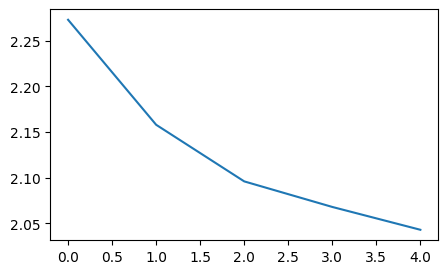

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(len(train_loss_mlp)), train_loss_mlp)

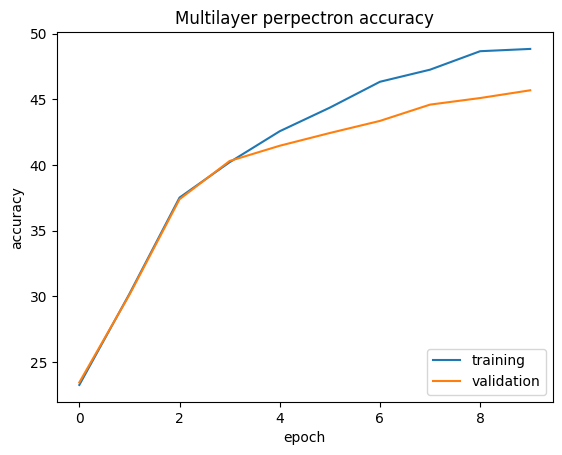

In [ ]:
plt.plot(np.arange(len(train_accuracy_mlp)), train_accuracy_mlp, label="training")
plt.plot(np.arange(len(test_accuracy_mlp)), test_accuracy_mlp, label = "validation")

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title('Multilayer perpectron accuracy')

plt.legend(loc='lower right')
plt.show()

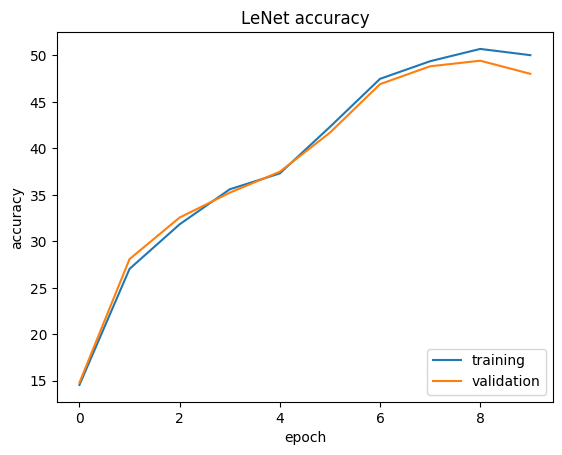

In [ ]:
plt.plot(np.arange(len(train_accuracy_lenet)), train_accuracy_lenet, label="training")
plt.plot(np.arange(len(test_accuracy_lenet)), test_accuracy_lenet, label = "validation")

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title('LeNet accuracy')

plt.legend(loc='lower right')
plt.show()

### 3.4 Visualisation des résultats

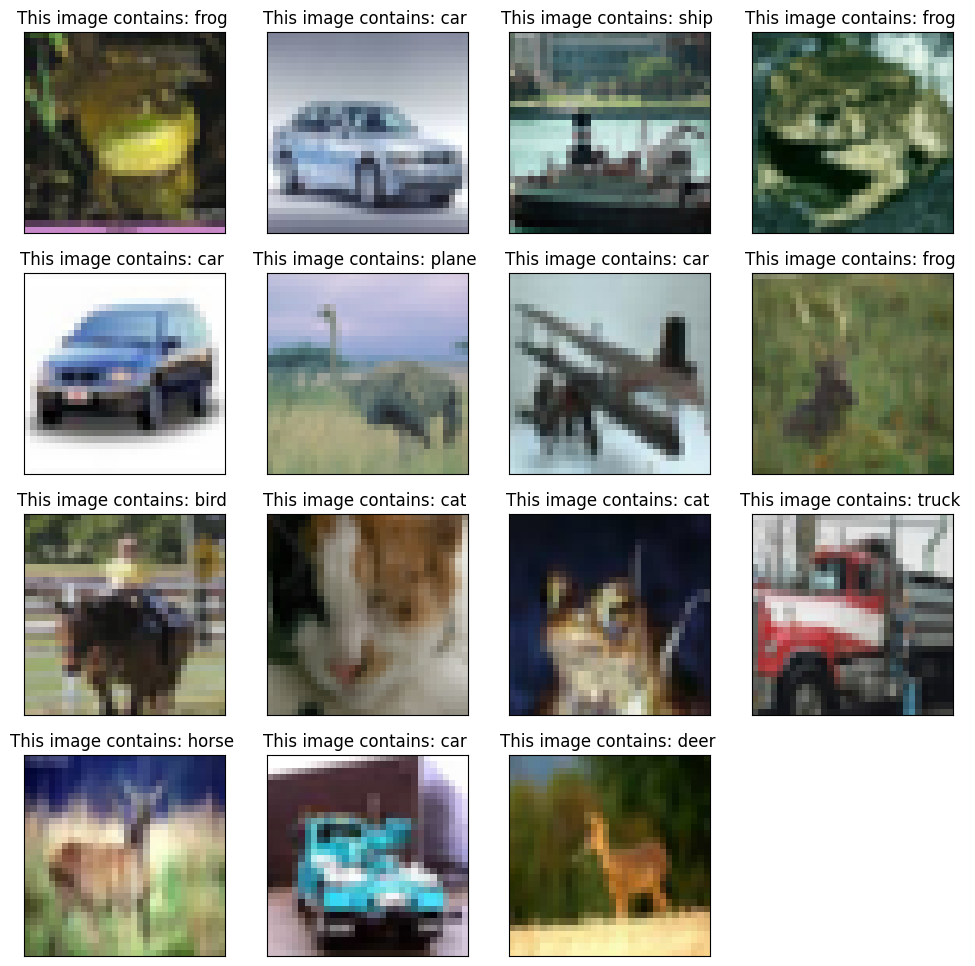

In [ ]:
test_features, test_labels = next(iter(test_loader))
outputs = mlp(test_features)
_, predicted = torch.max(outputs.data, 1)

plt.figure(figsize=(12, 12), facecolor='white')
for i in range(15):
    plt.subplot(4,4,i+1)
    img = unorm(test_features[i]).swapaxes(0, 2).swapaxes(0, 1)
    plt.imshow(img)

    plt.title('This image contains: {0:>2} '.format(classes[predicted[i].item()]))
    plt.xticks([]), plt.yticks([])
    plt.subplots_adjust()
plt.show()

### 3.2 Comparaison des modèles perceptron multicouches et réseau de neurones convolutif

MLP :
- Structure plate : Contrairement aux CNN, les MLP considèrent l'entrée comme un vecteur plat. Ils ne tiennent pas compte de la structure spatiale des données, ce qui les rend moins adaptés à la classification d'images.
- Apprentissage global : Les MLP apprennent des modèles globaux pour les caractéristiques, ce qui signifie qu'ils ne prennent pas en compte les relations spatiales locales entre les pixels d'une image.

CNN :
- Convolution : Les CNN utilisent des filtres de convolution pour extraire des caractéristiques locales des images. Cela permet de capturer des motifs tels que les bords, les textures et les formes.
- Hiérarchie des caractéristiques : Les CNN empilent plusieurs couches de convolution, de regroupement (*pooling*) et de couches entièrement connectées pour créer une hiérarchie de caractéristiques, ce qui leur permet de représenter des caractéristiques de plus en plus abstraites.
- Partage de poids : Les CNN partagent les poids des filtres de convolution, ce qui réduit considérablement le nombre de paramètres du modèle. Cela les rend plus efficaces pour l'apprentissage de caractéristiques.

En résumé, les MLP sont des réseaux de neurones classiques adaptés à des données tabulaires, tandis que les CNN sont spécialement conçus pour la vision par ordinateur et excellent dans la classification d'images grâce à la capture des caractéristiques locales et à la hiérarchie de caractéristiques.

**Consignes** :

Vous pouvez vous amusez à modifier en début de code le jeu de données utilisé pour l'exercice, et comparer les résultats avec le jeu de données <a href="https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST">MNIST</a> vu en cours.

### Accès à des GPU
Vous pouvez utiliser des GPU pour exécuter votre code du TP4 à venir.
Attention, cette ressource est limitée, utilisez-là à bon escient.

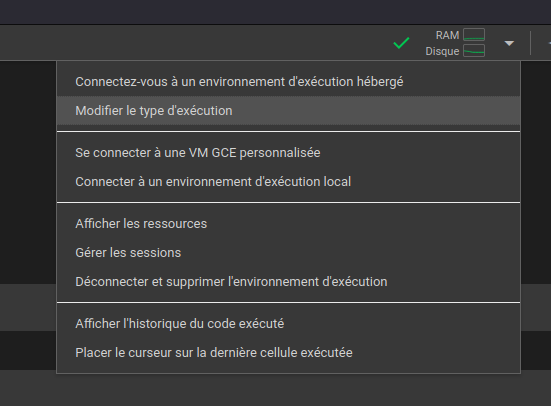

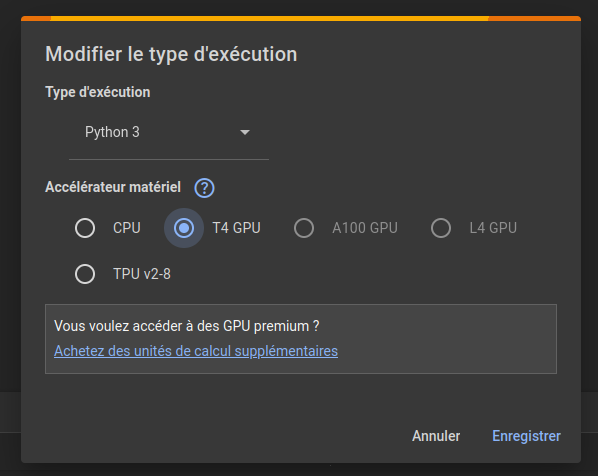